In [33]:
import pandas as pd
import numpy as np

import functions as u
import alphas as al
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

In [35]:
CANDLES_DIRECTORY_PATH = r'C:\Users\nikmastinen\virtual\AlphaSignals\data'
START_YEAR = 2023
END_YEAR = 2023
START_MONTH = 1
END_MONTH = 13
TIMEFRAME = '1h'
SYMBOL = 'BTCUSDT'

## Загрузка свечей

In [ ]:
class Candle:
    def __init__(self, line):
        current_line = [float(value) for value in line.split(',')]
        self.start = int(current_line[0]) // 1000
        self.open = current_line[1]
        self.high = current_line[2]
        self.low = current_line[3]
        self.close = current_line[4]
        self.volume = current_line[5]
        self.end = int(current_line[6]) // 1000
        self.quote_volume = current_line[7]
        self.NOT = int(current_line[8])
        self.TBV_base = current_line[9]
        self.TBV_quote = current_line[10]
        self.ignore = current_line[11]

def load_coins(file_coins_path: str) -> list[str]:
    with open(file_coins_path) as f:
        lines = f.readlines()
        res_coins = [line[:-5] for line in lines]
    return res_coins

def load_candles(
        dir_candles_path: str,
        start_year: int,
        start_month: int,
        end_year: int,
        end_month: int,
        timeframe: str,
        target_coins: list[str],
) -> dict[str, list[Candle]]:
    candles_ = dict()
    candles_timeframe: dict[str, list[Candle]] = dict()
    for tradingPair in target_coins:
        candles_coin = []
        for year in range(start_year, end_year + 1):
            if start_year < year < end_year:
                months = range(1, 13)
            elif start_year == end_year:
                months = range(start_month, end_month)
            elif year == start_year:
                months = range(1, end_month)
            else:
                months = range(start_month, 13)
            for month in months:
                path = dir_candles_path + r"/{}-{}-{}-{}.csv".format(tradingPair, timeframe, year, f"{month:02}")
                try:
                    with open(path, 'r') as f:
                        data = f.readlines()
                        print(path)
                        # break
                        candles_coin.extend([Candle(line) for line in data])
                    print(path, 'ok')
                except:
                    continue
                

        candles_timeframe[tradingPair] = candles_coin

    candles_[timeframe] = candles_timeframe
    return candles_[timeframe]

candles: list[Candle] = load_candles(
    dir_candles_path=CANDLES_DIRECTORY_PATH,
    start_year=START_YEAR,
    start_month=START_MONTH,
    end_year=END_YEAR,
    end_month=END_MONTH,
    timeframe=TIMEFRAME,
    target_coins=[SYMBOL]
)[SYMBOL]

In [ ]:
df = pd.DataFrame.from_dict({
    'start': [i.start for i in candles],
    'end': [i.end for i in candles],
    'open': [i.open for i in candles],
    'close': [i.close for i in candles],
    'high': [i.high for i in candles],
    'low': [i.low for i in candles],
    'volume': [i.volume for i in candles]
})
df

## Препроцессинг

In [39]:
df['vwap'] = u.vwap(df)
df['returns'] = u.returns(df)
df['adv20'] = u.adv(df, 20)
df


,start,end,open,close,high,low,volume,vwap,returns,adv20
0,1672531200,1672534799,16541.77,16529.67,16545.70,16508.39,4364.83570,16529.67,NaN,NaN
1,1672534800,1672538399,16529.59,16551.47,16556.80,16525.78,3590.06669,16551.47,0.001319,NaN
2,1672538400,1672541999,16551.47,16548.19,16559.77,16538.14,3318.84038,16548.19,-0.000198,NaN
3,1672542000,1672545599,16548.19,16533.04,16548.19,16518.21,4242.08050,16533.04,-0.000916,NaN
4,1672545600,1672549199,16533.04,16521.85,16535.97,16511.92,4285.00909,16521.85,-0.000677,NaN
...,...,...,...,...,...,...,...,...,...,...
8010,1701370800,1701374399,37739.36,37749.34,37796.00,37689.56,569.39380,37749.34,0.000264,1126.101935
8011,1701374400,1701377999,37749.34,37730.94,37765.00,37695.44,618.30774,37730.94,-0.000487,1118.305795
8012,1701378000,1701381599,37730.93,37739.10,37764.37,37696.35,382.70595,37739.10,0.000216,1108.028313
8013,1701381600,1701385199,37739.09,37694.06,37809.99,37680.80,384.42635,37694.06,-0.001193,1089.776403


In [ ]:
for n in range(101):
    print(n)
    name = 'alpha{}'.format(n + 1)
    func = 'al.{}'.format(name)
    temp_func = eval(func)
    df[name] = temp_func(df)
    print(n, 'ok')
    

In [41]:
df.to_csv('alphas_2023_1h.csv')

In [42]:
df = pd.read_csv('alphas_2023_1h.csv')

### Стандартное разбиение на тренировочный, тестовый и валидационный

In [43]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [44]:
data = df.copy()

y = data['returns'].shift(-1)
data['labels'] = y
data = data.copy()
data = data[1000:-1000]
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna(axis=1)
data = data.reset_index()
all_data = data.copy()

data = data.drop('index', axis=1)
data = data.drop('start', axis=1)
data = data.drop('end', axis=1)
data = data.drop('Unnamed: 0', axis=1)
data = data.drop('open', axis=1)
data = data.drop('close', axis=1)
data = data.drop('high', axis=1)
data = data.drop('adv20', axis=1)
data = data.drop('volume', axis=1)
data = data.drop('low', axis=1)
data.head()

,returns,alpha1,alpha2,alpha3,alpha4,alpha6,alpha7,alpha8,alpha9,alpha10,...,alpha81,alpha86,alpha88,alpha92,alpha95,alpha96,alpha98,alpha99,alpha101,labels
0,-0.001962,-0.083729,-0.578185,0.075613,-0.666667,0.077019,-1.00,-0.428000,42.64,0.750187,...,-1,0,0.661634,0.285714,True,0.625000,-0.813788,-0.483163,-0.726393,0.000264
1,0.000264,-0.260693,-0.618587,-0.044682,-0.333333,-0.018124,-1.00,-0.394000,-5.72,0.460819,...,-1,0,0.666001,0.285714,True,1.000000,-0.678757,-0.418590,0.146430,-0.002066
2,-0.002066,-0.423837,-0.135044,-0.041809,-0.111111,-0.004895,0.25,-0.317250,44.83,0.757799,...,-1,0,0.664255,0.526316,False,0.538462,-0.488181,-0.326523,-0.395811,0.000397
3,0.000397,-0.083729,0.423112,-0.166676,-0.222222,-0.134495,-1.00,-0.320625,-8.60,0.439980,...,-1,0,0.675483,0.421053,True,0.538462,-0.158503,-0.302308,0.292325,0.000404
4,0.000404,-0.260693,0.455664,-0.230247,-0.222222,-0.198415,-1.00,-0.385625,-8.75,0.439107,...,-1,0,0.657767,0.315789,False,0.538462,0.072513,-0.273931,0.125398,0.007022


In [46]:
threashold = 2 / 3

data_learn = data[0:int(len(data) * threashold)]
data_validate = data[int(len(data) * threashold):]

all_data_learn = all_data[0:int(len(all_data) * threashold)]
all_data_validate = all_data[int(len(all_data) * threashold):]

In [47]:
y = data_learn['labels'].copy()
X = data_learn.drop('labels', axis=1)

y[y > 0] = 1
y[y <= 0] = 0

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.6, 
                                                    shuffle=False,
                                                   stratify=None)

### Попробуем использовать PCA (неактуально)

In [43]:
pca = PCA(n_components=10)

X_train_reduced = pca.fit_transform(X_train)

params = {
    "n_estimators": 1000,
    "max_depth": 6,
    # "min_samples_split": 5,
    # "learning_rate": 0.01,
    # "loss": "squared_error",
}
reg = ensemble.RandomForestClassifier(**params)
reg.fit(X_train_reduced, y_train)

RandomForestClassifier(max_depth=6, n_estimators=1000)

In [44]:
pca.transform(X_test)

array([[ 2.00113338e+04, -3.89184133e+03, -9.26405301e+02, ...,
        -6.54175888e+01, -2.68857889e-01,  5.50252439e+01],
       [ 2.01016937e+04, -4.00484247e+03, -9.53026866e+02, ...,
         7.63726873e+01, -1.36359135e+01,  4.99232726e+01],
       [ 2.02491125e+04, -4.12945896e+03, -1.01963639e+03, ...,
         6.78659117e+01,  3.04602941e+01,  3.29159609e+01],
       ...,
       [ 3.34869750e+04,  1.96556218e+03, -6.90626685e+02, ...,
        -1.98205117e+01, -9.70520139e+01, -3.86292764e-02],
       [ 3.34483053e+04,  1.26889175e+03, -7.02066759e+02, ...,
        -4.80810411e+01, -5.59245526e+01, -6.22390015e+00],
       [ 3.37192293e+04,  5.89451947e+03, -1.01312647e+03, ...,
         2.48276889e+02, -3.14073953e+02, -1.00489575e+02]])

In [300]:
# X_test = X_test.reset_index()
# y_test = y_test.reset_index()
# for x, y in zip(X_test.iterrows(), y_test):
#     print(x[1])
#     print(pca.transform([x[1]]))
#     values = reg.predict(pca.transform([x[1]]))
#     print(values)
#     break
y_pred = reg.predict(pca.transform(X_test))
1 - mean_squared_error(y_pred, y_test)

0.5047426221500937

### Попробуем Random Forest Classifier (Без PCA)

In [50]:
params = {
    "n_estimators": 3200,
    "max_depth": 12,
    "min_samples_split": 5,
}

reg = ensemble.RandomForestClassifier(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_train, reg.predict(X_train))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0004


In [52]:
# чем меньше сделок, выше порог, когда мы делаем предсказание, тем больше точность
def get_prediction_values(X_test, y_test, bound = 1.3):
    y_pred = reg.predict_proba(X_test)

    err = 0
    cnt = 0
    for t, p in zip(y_test, y_pred):
        if p[0] / p[1] > bound:
            err += abs(t - 0)
            cnt += 1
        if p[1] / p[0] > bound:
            err += abs(t - 1)
            cnt += 1
    return 1 - err / cnt, cnt / len(y_test)
# 1 - mean_squared_error(y_test, reg.predict(X_test))

In [55]:
def plot_stats(X, y):
    stats = []
    for i in np.linspace(1, 1.8, 30):
        stats.append(get_prediction_values(X, y, i))

    plt.rcParams['figure.figsize'] = (10, 5)
    plt.rcParams["figure.dpi"] = 500

    plt.ylabel('Точность предсказания следующей минутной свечи', fontsize=10, color='grey')
    plt.xlabel('Раз в столько свечей делается сделка', fontsize=10, color='grey')

    plt.title('Зависимость точности предсказания от количества сделок')
    plt.plot([1 / i[1] for i in stats], [i[0] for i in stats], '.r-')
    # print(stats)
    plt.show()

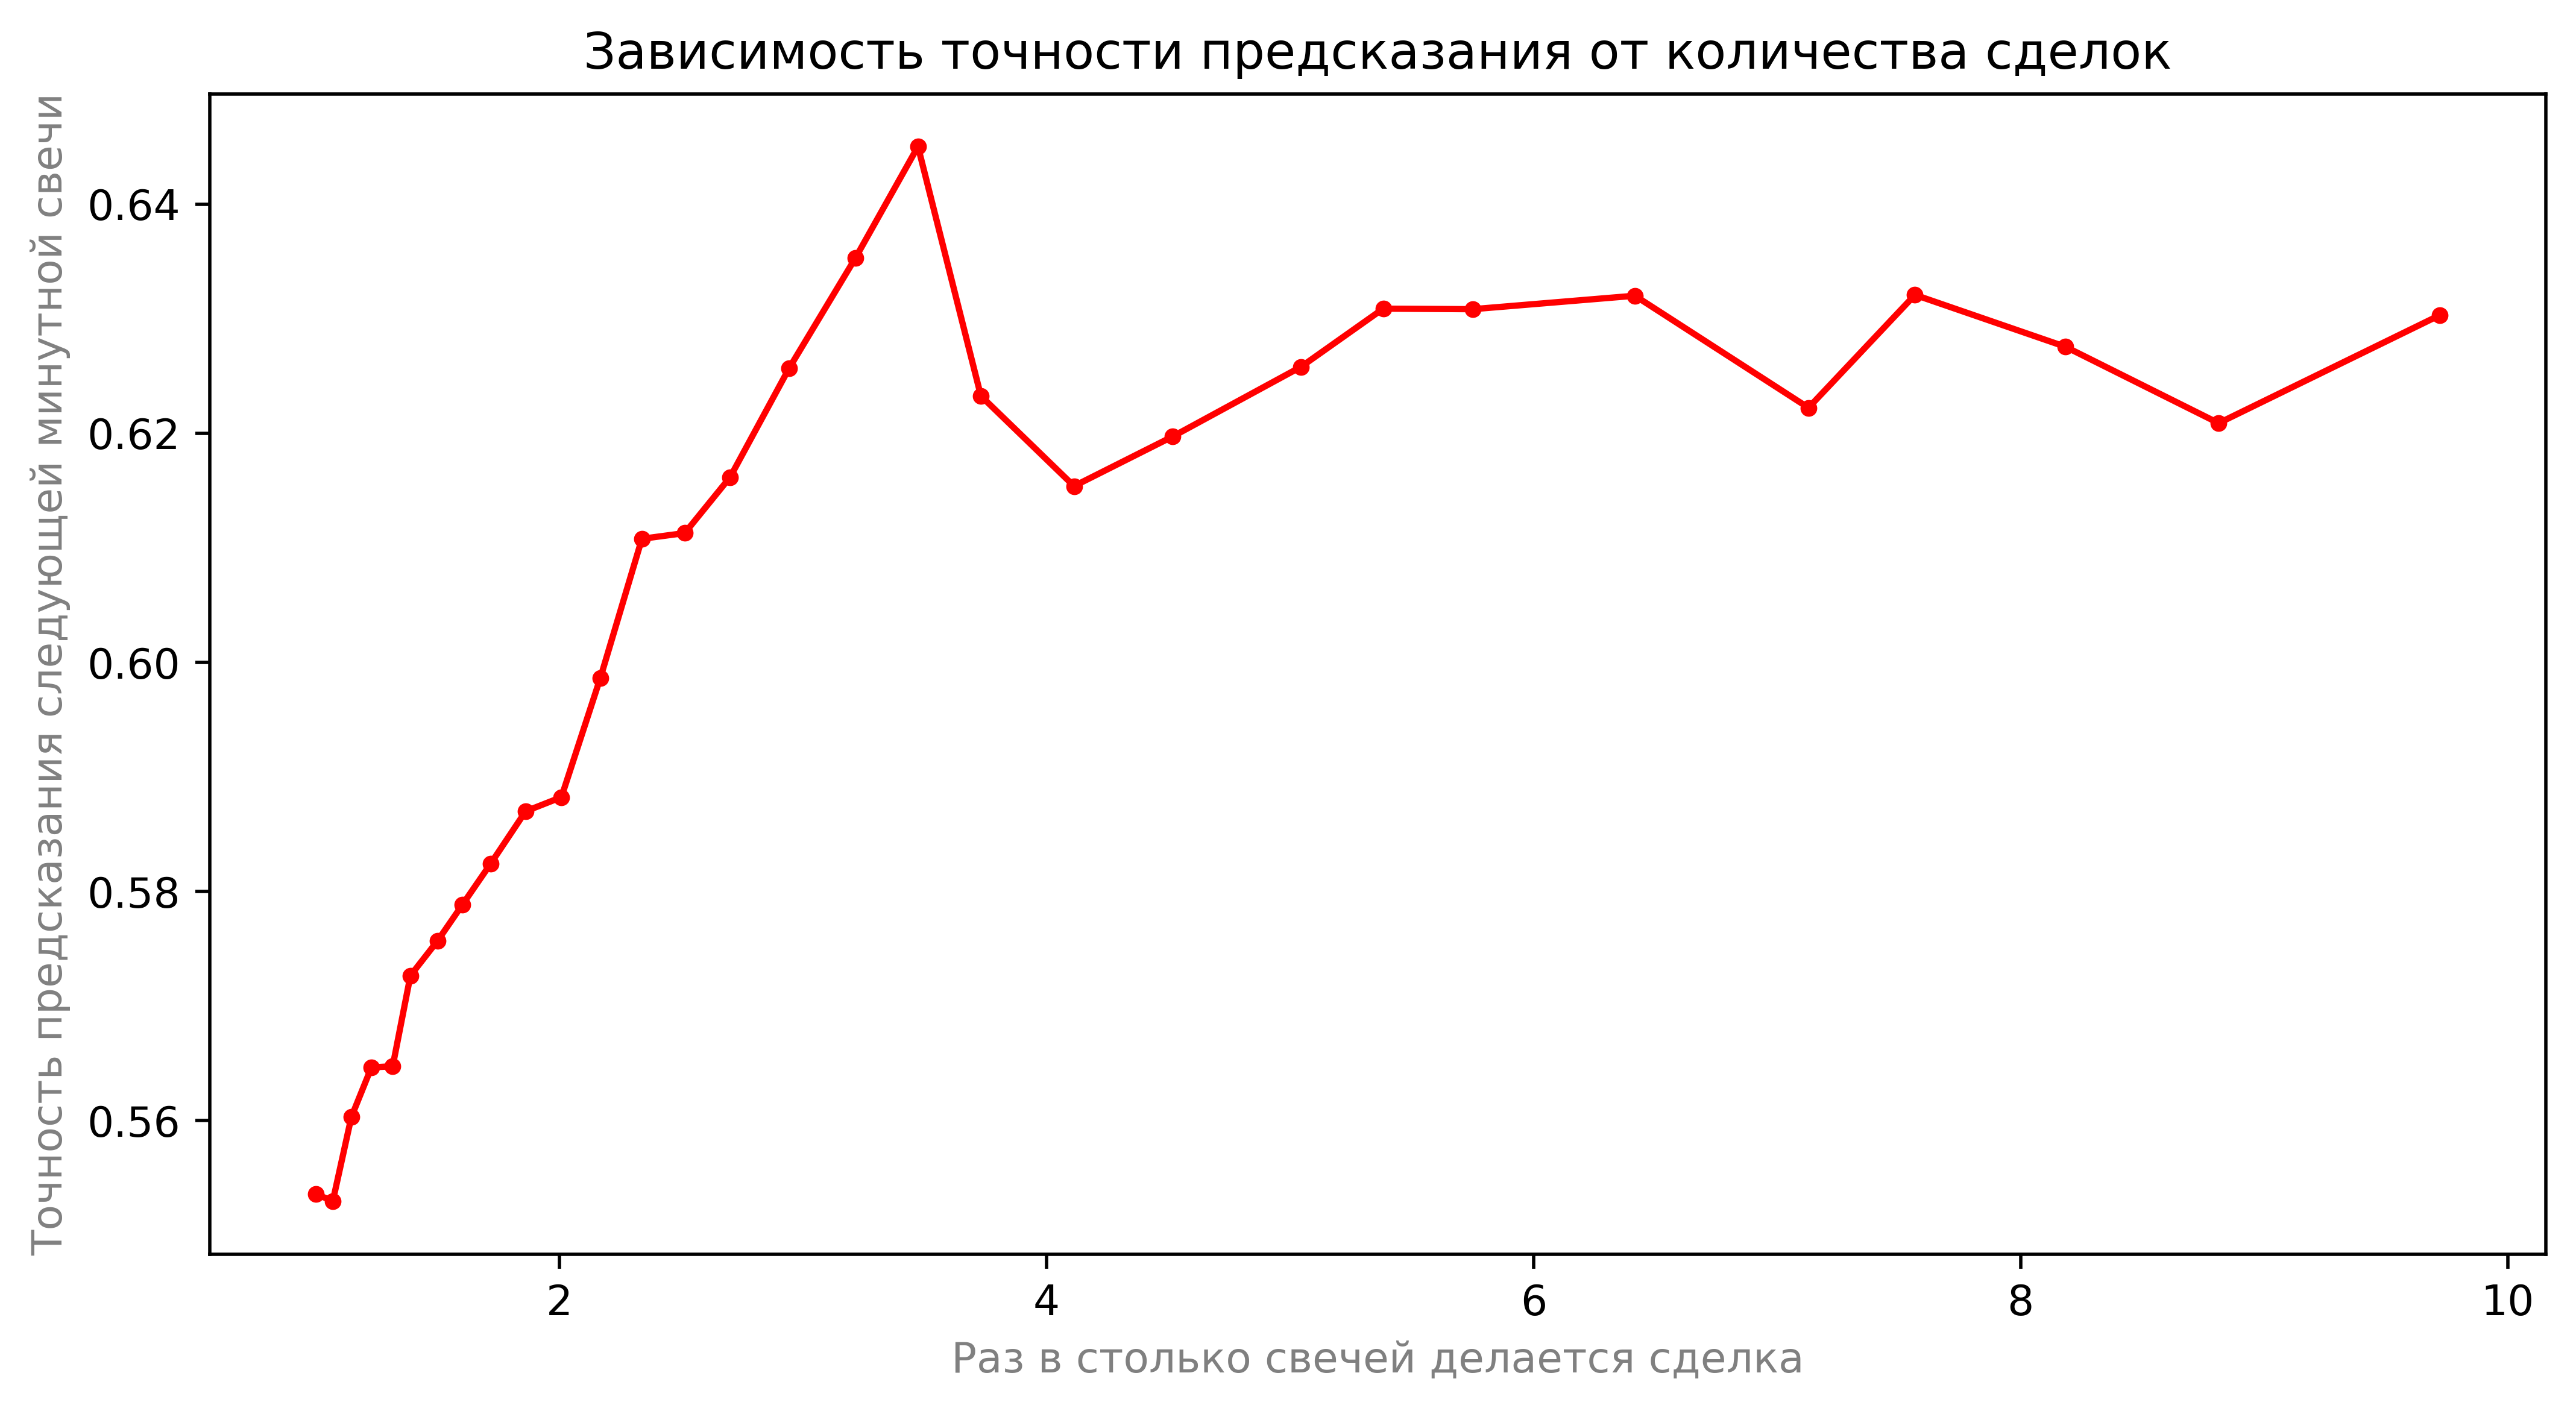

In [56]:
plot_stats(X_test, y_test)

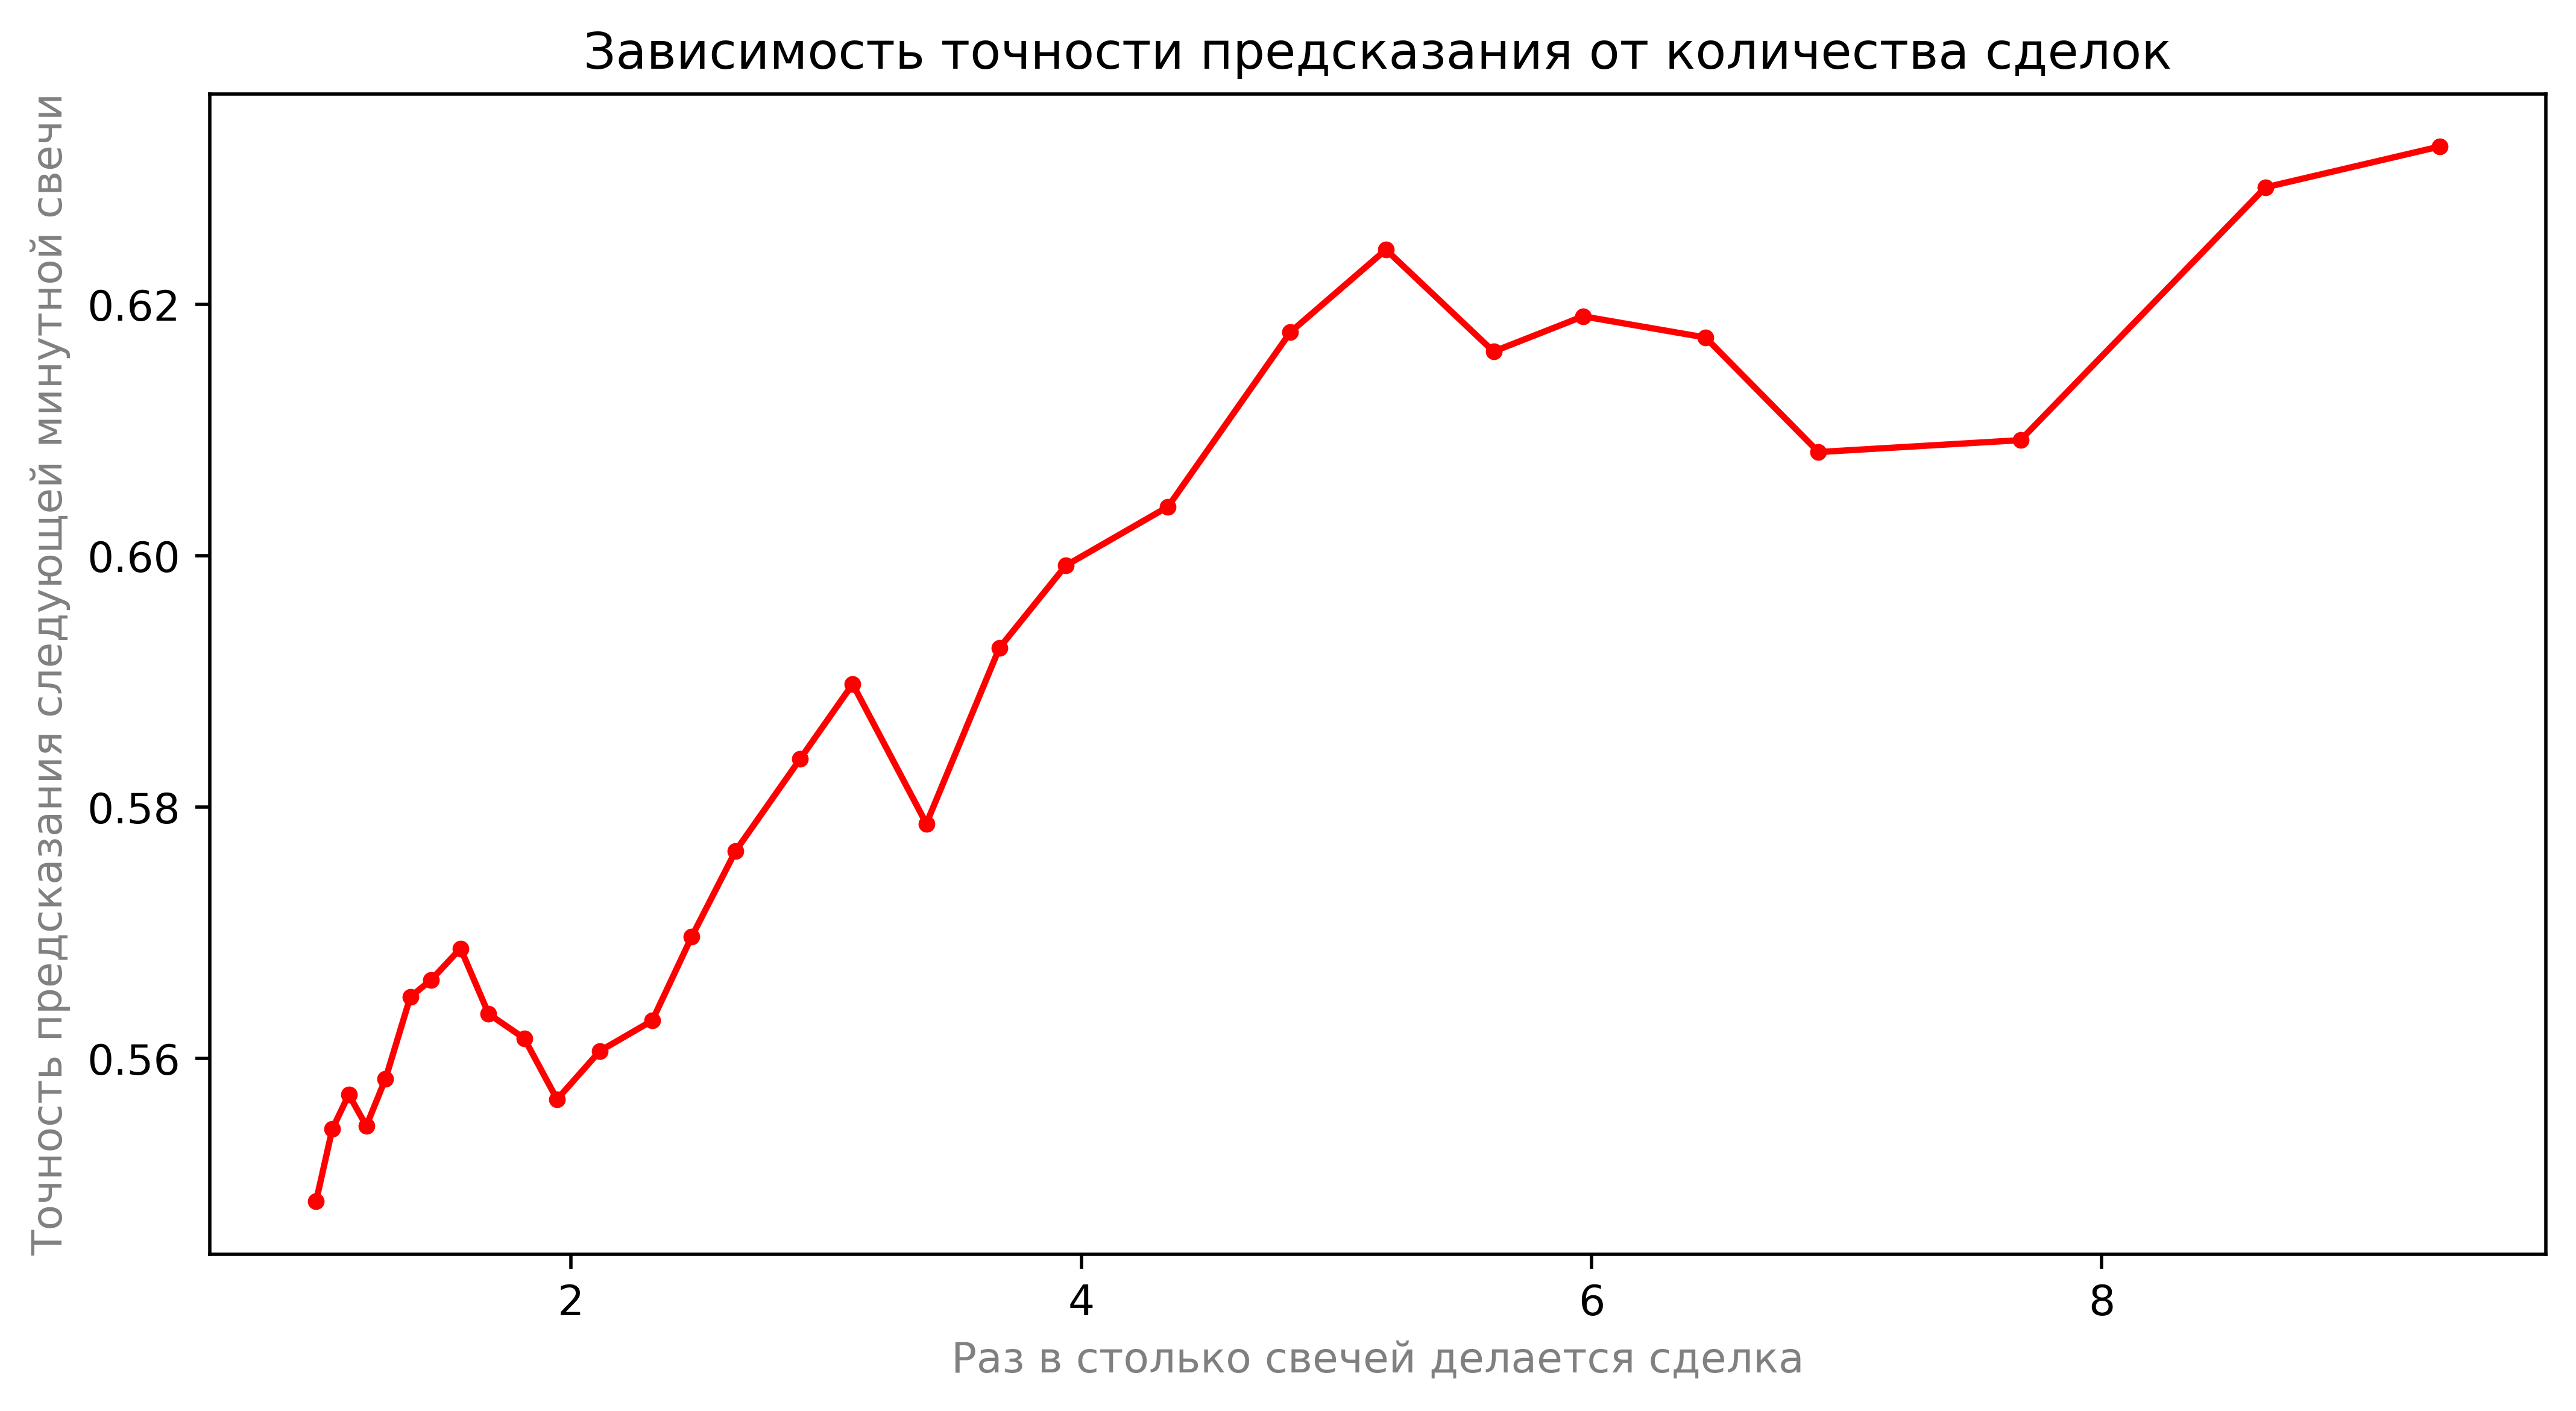

In [57]:

X_validate = data_validate.drop('labels', axis = 1)
y_validate = data_validate['labels'].copy()
y_validate[y_validate > 0] = 1
y_validate[y_validate <= 0] = 0

plot_stats(X_validate, y_validate)

## Проверим сигналы

Изобразим на графики те моменты, когда нам даются сигналы (на валидацтионной выборке)

In [72]:
def get_points(X_test, all_data, bound = 1.6):
    y_pred = reg.predict_proba(X_test)
    err = 0
    cnt1 = []
    cnt2 = []
    res1 = []
    res2 = []
    for p, cl, c in zip(y_pred, all_data['close'], all_data['start']):
        if p[0] / p[1] > bound:
            res1.append(cl)
            cnt1.append(c)
        elif p[1] / p[0] > bound:
            res2.append(cl)
            cnt2.append(c)
#         else:
#             res.append(0)
    return res1, cnt1, res2, cnt2
r1, cnt1, r2, cnt2 = get_points(X_validate, all_data_validate)
len(np.linspace(0, X_validate.shape[0], X_validate.shape[0]))

2005

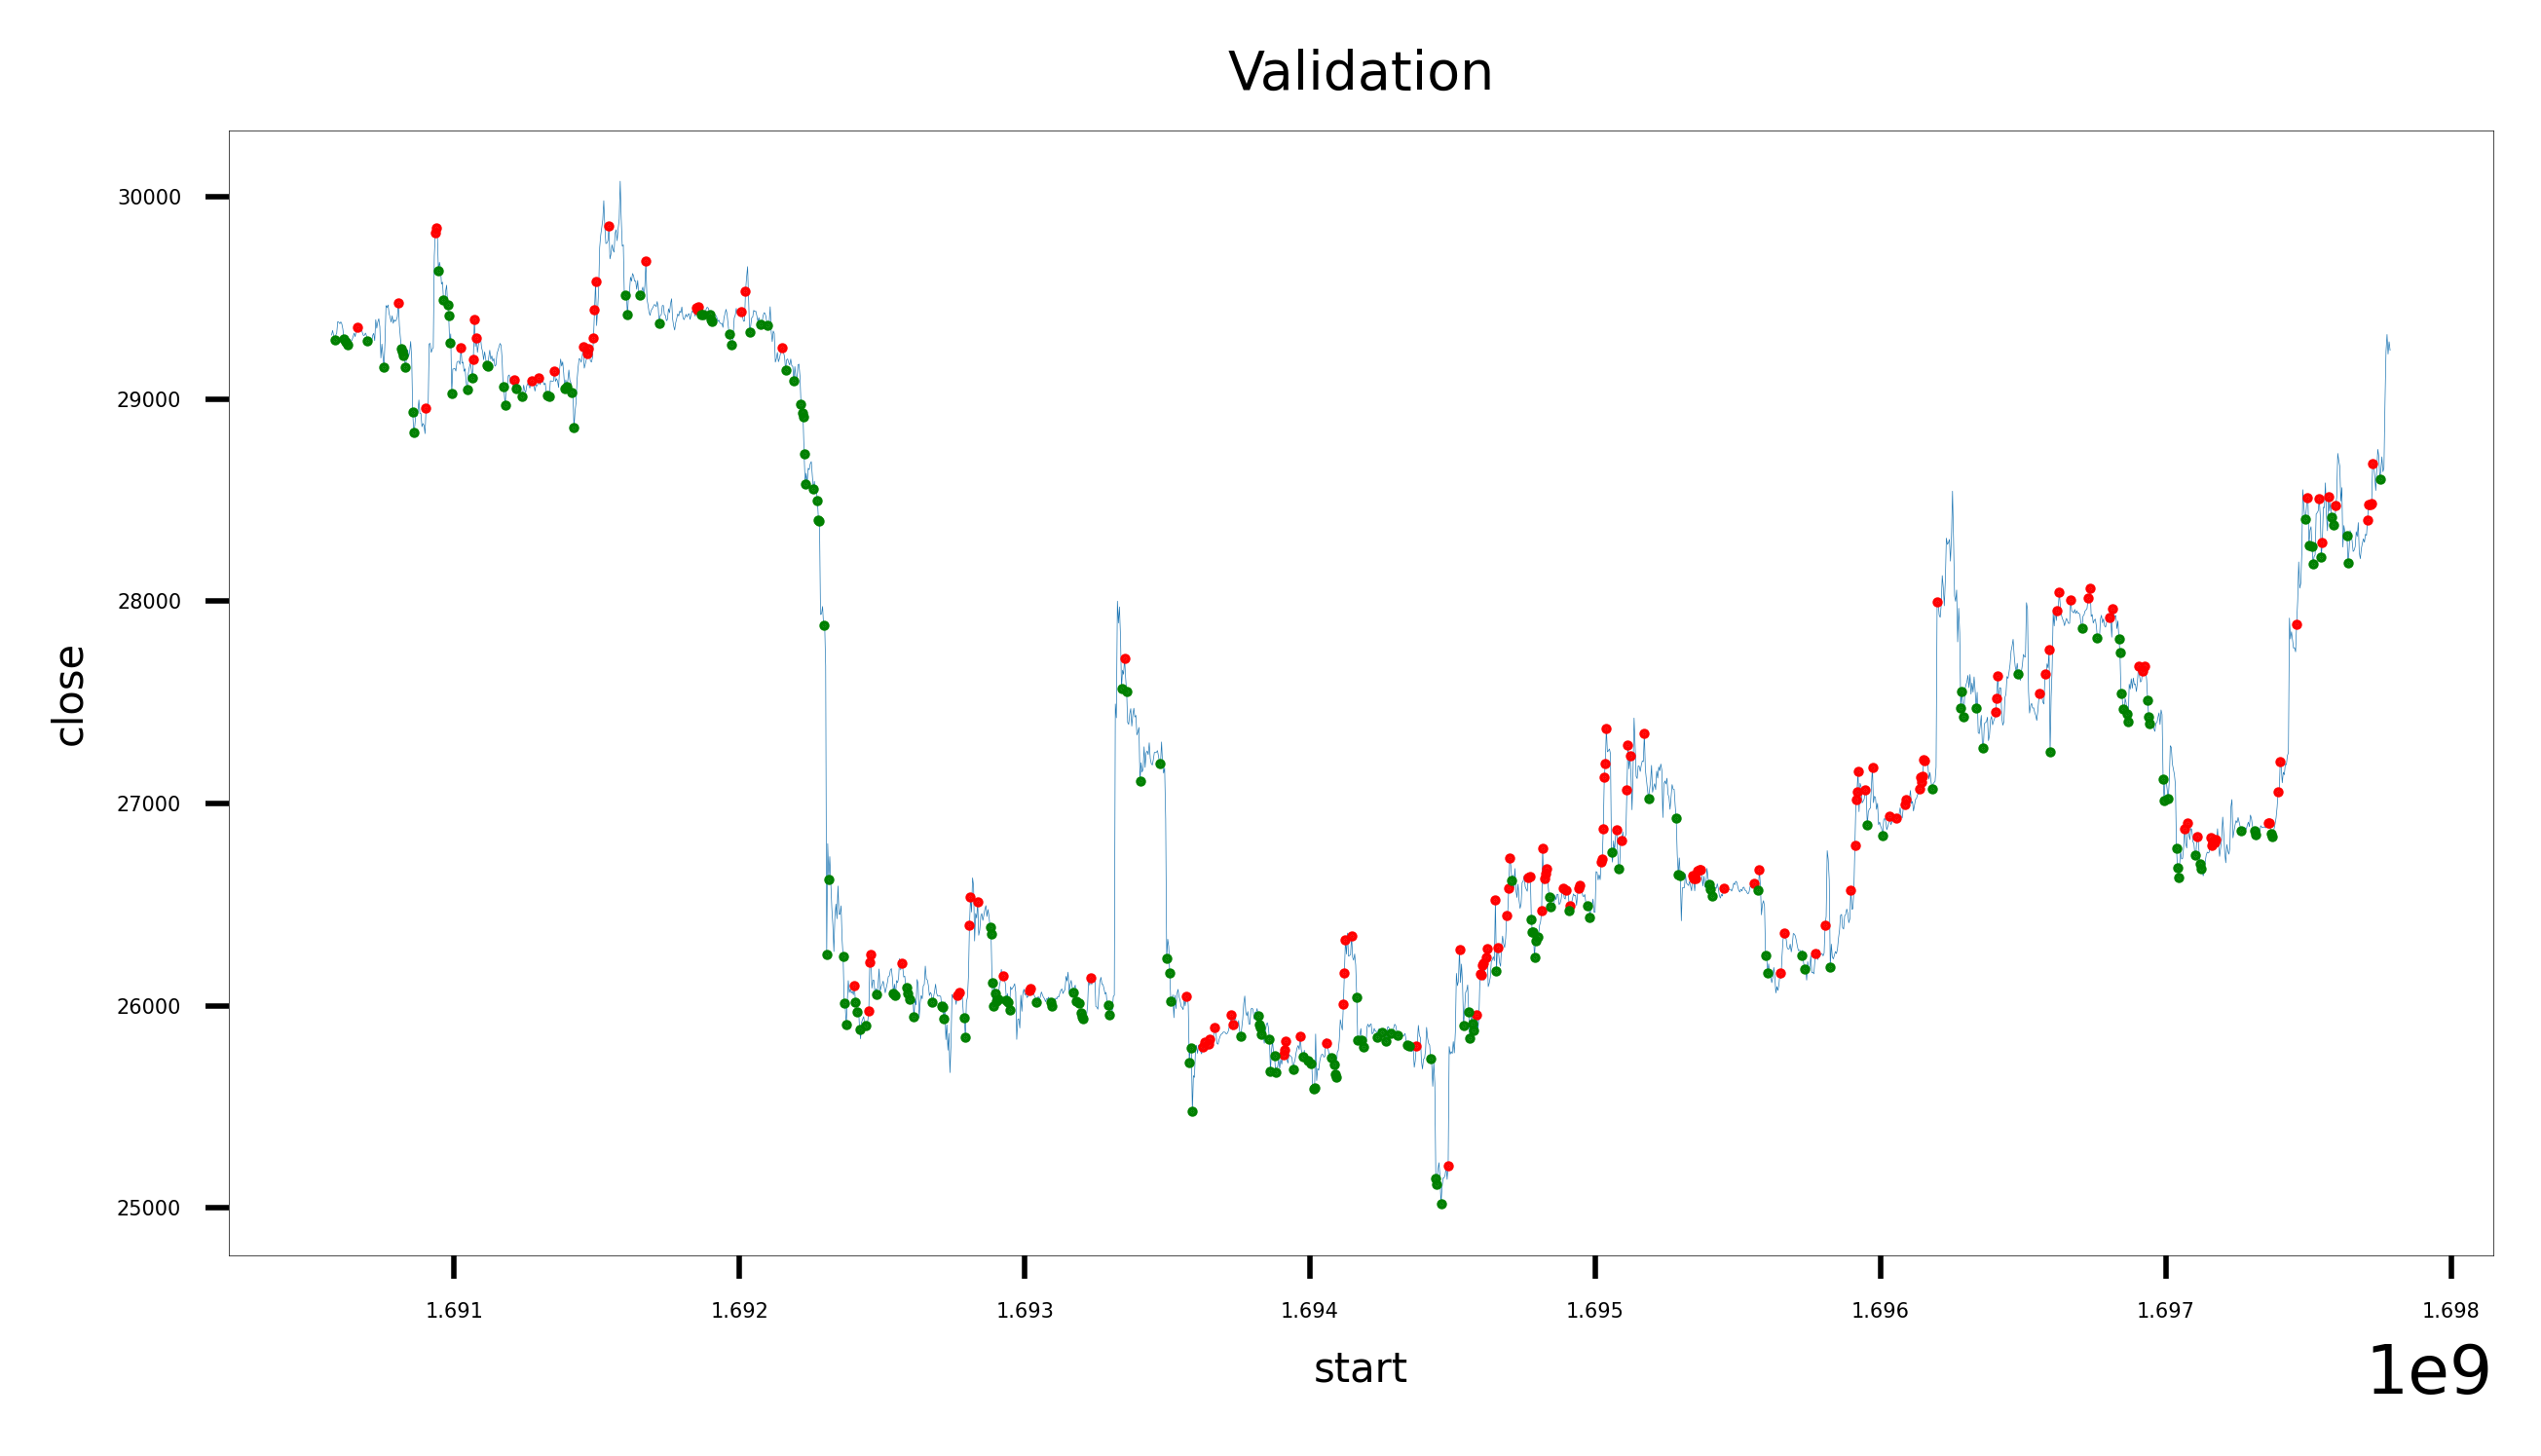

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(all_data_validate['start'], all_data_validate['close'], linewidth=0.1)
ax.plot(cnt1, r1, 'ro', markersize=0.5)  # red markers
ax.plot(cnt2, r2, 'go', markersize=0.5)  # green markers

ax.set_xlabel('start')
ax.set_ylabel('close')
ax.set_title('Validation')

ax.set_xlabel('start', fontsize=6)  # smaller font for x-label
ax.set_ylabel('close', fontsize=6)  # smaller font for y-label
ax.set_title('Validation', fontsize=8)  # smaller font for title

ax.tick_params(axis='both', labelsize=3)  
ax.spines['left'].set_linewidth(0.1)  # reduce border width of left spine
ax.spines['bottom'].set_linewidth(0.1)  # reduce border width of bottom spine
ax.spines['right'].set_linewidth(0.1)  # reduce border width of right spine
ax.spines['top'].set_linewidth(0.1)  # reduce border width of top spine

plt.show()

## Тестирование

In [86]:
def strategy_simulator(
        leverage: int,
        index: int,
        target: float,
        is_long: bool
):
    enter_price: float = candles[index].open
    fee = 0.0004
    delta_usd: float = -target * enter_price if is_long else target * enter_price
    delta_usd -= abs(target * enter_price * fee)
    total_target: float = target if is_long else -target

    s = 0
    
    for i in range(index + 2, len(candles)):
        if i == len(candles) - 1:
            raise IndexError

        ind = i

        candle = candles[i]

        if is_long:
            if candle.open >= (1 + s) * enter_price:
                delta_usd += total_target * candle.open
                delta_usd -= abs(total_target * candle.open * fee)
                break
                
            if candle.open <= (1 - s) * enter_price:
                delta_usd += total_target * candle.open
                delta_usd -= abs(total_target * candle.open * fee)
                break

        if not is_long:
            if candle.open <= (1 - s) * enter_price:
                delta_usd += total_target * candle.open
                delta_usd -= abs(total_target * candle.open * fee)
                break

            if candle.open >= (1 + s) * enter_price:
                delta_usd += total_target * candle.open
                delta_usd -= abs(total_target * candle.open * fee)
                break
    return delta_usd, ind

In [87]:
all_data_validate
X_validate

,returns,alpha1,alpha2,alpha3,alpha4,alpha6,alpha7,alpha8,alpha9,alpha10,...,alpha77,alpha81,alpha86,alpha88,alpha92,alpha95,alpha96,alpha98,alpha99,alpha101
4010,0.000234,0.350738,-0.026963,-0.594638,-0.666667,-0.448030,-1.000000,-0.284375,-6.85,0.451897,...,0.498939,0,-1,0.333333,0.714286,False,0.538462,0.251783,-0.636020,0.155486
4011,0.000767,0.350738,0.696625,-0.481416,-0.555556,-0.380001,-1.000000,-0.347625,-22.48,0.351510,...,0.418341,0,0,0.333333,0.428571,False,0.538462,0.053226,-0.642830,0.408869
4012,-0.000842,0.103802,0.489727,-0.329585,-0.777778,-0.272482,-1.000000,-0.376875,24.71,0.656227,...,0.492701,0,0,0.723269,0.142857,False,0.538462,0.060986,-0.378277,-0.402109
4013,-0.000743,-0.083729,0.571679,-0.425622,-0.555556,-0.288449,-1.000000,-0.274875,21.77,0.640067,...,0.543731,0,0,0.811354,0.142857,False,0.538462,0.160078,-0.059551,-0.922028
4014,0.000756,-0.260693,0.360678,-0.471889,-0.555556,-0.329565,-1.000000,-0.269625,-22.14,0.353506,...,0.523144,0,0,0.826825,0.142857,False,0.538462,0.236994,-0.278652,0.614876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6010,0.008812,0.350738,-0.228207,-0.533172,-1.000000,-0.708127,-1.000000,-0.935875,-255.38,0.020339,...,0.915726,-1,0,0.078228,0.714286,True,0.538462,0.302035,-0.358179,0.532041
6011,0.002844,0.350738,-0.202630,-0.528341,-1.000000,-0.565594,-1.000000,-0.915125,-83.16,0.866296,...,0.955982,-1,0,0.061385,0.789474,True,1.000000,0.365974,-0.379745,0.475717
6012,-0.003301,0.103802,-0.498817,-0.609098,-0.888889,-0.667525,-0.983333,-0.936375,96.79,0.890442,...,0.954477,-1,0,0.067124,0.736842,False,0.538462,0.239227,-0.446715,-0.413058
6013,0.002082,-0.083729,-0.397471,-0.566459,-1.000000,-0.513443,-1.000000,-0.948625,-60.85,0.188295,...,0.841234,0,0,0.066625,0.631579,True,0.538462,0.131862,-0.504099,0.553328


In [88]:
def signal(i):
    if candles[i].start in ty1:
        if candles[i].open > candles[i - 1].open:
            return False
        if candles[i].open < candles[i - 1].open:
            return True
    return None

In [ ]:
rew = []  # прибыль за сделки
index = 0  # индекс свечи, начиная с которого запускается стратегия

ind = []
last = 0

tp = 0  # успешные сделки
sl = 0  # неуспешные сделки

usd_balance = 100  # сумма

vv = 0


while index < len(candles):
    last = index
    target = usd_balance / candles[index].open
    try:
        sig = signal(index)
        if sig is None:
            index += 1        
            rew.append(0)
            ind.append(index)
            continue
        # print(sig)
        r, index = strategy_simulator(
            
            index=index, 
            is_long=sig,
            target=target,
            leverage=5
        )
        for j in range(last, index):
            rew.append(0)
            ind.append(j)
        ind.append(index)
        rew.append(r)

        tp += 1 if r > 0 else 0
        sl += 1 if r < 0 else 0
        index += 1        
        rew.append(0)
        ind.append(index)
       
    except IndexError:
        # ind.pop()
        break
print(tp, sl)

In [ ]:
plt.rcParams["figure.figsize"] = (12,9)

fig = go.Figure(
    [
        go.Scatter(x=ind, y=np.cumsum(rew)),
    ]
)
fig.update_layout(
    autosize=False,
    width=900,
    height=600,)
fig.show()